<a href="https://colab.research.google.com/github/OnePassio/CE888/blob/master/Assignment2/Experiment_2_Build_Prediction_deal_with_Covariance_Manual_Drop_High_Shift_Detection_By_Visualization_Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Target of this experiment**
- This experiment target: Detect High Covariant shift features by manual, and then building a prediction without use these high Covariant shift features.
- Classifier Model use **LinearDiscriminantAnalysis** 
- The result will be upload to Kaggle to check score.
- Result:
   + 4-Kfold stratified cross-validation: **0.61517 +/- 0.00053**
   + **Kaggle score**: **0.58978**

## **Load Library**

In [0]:
# Initial Library
# data analysis
import pandas as pd
import numpy as np
import random as rand

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warning message
import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# **1.Load Data from Kaggle**
Source Data: https://www.kaggle.com/c/microsoft-malware-prediction/

!kaggle competitions download -c microsoft-malware-prediction

In [0]:
# load data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "thomastran89" # username from the json file
os.environ['KAGGLE_KEY'] = "be79bdf7a2010c5b7a9aeac8ed316490" # key from the json file
!kaggle competitions download -c microsoft-malware-prediction # api copied from kaggle
# Unzip the data
!sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
# Check files after unzip
!ls

 84% 113M/134M [00:01<00:00, 96.8MB/s] 
100% 134M/134M [00:01<00:00, 111MB/s] 
 99% 757M/768M [00:06<00:00, 136MB/s]
100% 768M/768M [00:06<00:00, 121MB/s]
 98% 660M/672M [00:05<00:00, 134MB/s]
100% 672M/672M [00:05<00:00, 137MB/s]
/bin/bash: sample_submission.csv.zip: command not found
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
as2_experiment01.csv  sample_data		 test.csv.zip
fixed_data	      sample_submission.csv.zip  train.csv
fixed_data.zip	      test.csv			 train.csv.zip


In [0]:
# load partial data for test first
sample_size= 5000000 # data too heavy and can not load by Google Colab -> Test on 1M first rows

# Load Train Data
df_train_org = pd.read_csv("train.csv",skiprows=0, nrows=sample_size)

# Load Test Data
df_test_org= pd.read_csv("test.csv") #skiprows=0, nrows=sample_size)


# **2. Preprocessing Data**

## 2.1. Remove some unused features to build model of dataset
remove column field data have a unique ID 

In [0]:
#cache
df_train_id=df_test_org['MachineIdentifier'].copy()
df_test_id=df_test_org['MachineIdentifier'].copy()
# remove id
df_train=df_train_org.drop('MachineIdentifier',axis=1)
df_test=df_test_org.drop('MachineIdentifier',axis=1)

df_train.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2341.0,...,HDD,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2405.0,...,HDD,102385.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4909.0,317701.0,4.0,5.0,1972.0,...,SSD,113907.0,0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,2273.0,...,UNKNOWN,227116.0,0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,355.0,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,18,37376.0,NaN,277.0,75,windows1

### 2.2. Fill NaN missing value
Replace NaN value by mean value of their columns

In [0]:
## missing values on train.csv
for i in df_train.columns:
    if df_train[i].dtype == 'object':
      df_train[i] = df_train[i].fillna(df_train[i].mode().iloc[0])
    if (df_train[i].dtype == 'int' or df_train[i].dtype == 'float'):
      df_train[i] = df_train[i].fillna(np.mean(df_train[i]))

## missing values on test.csv
for i in df_test.columns:
    if df_test[i].dtype == 'object':
      df_test[i] = df_test[i].fillna(df_test[i].mode().iloc[0])
    if (df_test[i].dtype == 'int' or df_test[i].dtype == 'float'):
      df_test[i] = df_test[i].fillna(np.mean(df_test[i]))
      
df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,on,0.003175,108.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,0.000011,0.0,Retail,0.000281,807.0,8554.0,1,4.290840e-07,0.0,0,0,0.0,0.0,7.0
1,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,68,71395.0,24.952712,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,on,0.003175,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,lion,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,0.000011,0.0,Retail,0.000281,554.0,33105.0,1,4.290840e-07,0.0,0,0,0.0,1.0,12.0
2,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,1604.120797,49480.0,2.0,1.0,1,201,66202.0,24.952712,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,on,0.003175,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,lion,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,0.000011,0.0,Retail,0.000281,556.0,63396.0,1,4.290840e-07,0.0,0,0,0.0,1.0,11.0
3,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,1604.120797,42160.0,2.0,1.0,1,29,120917.0,24.952712,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,on,0.003175,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLEL

## 2.3. label encoding

In [0]:
# encoder, alternative is convert to dummies
number = LabelEncoder()
for i in df_train.columns:
    if (df_train[i].dtype == 'object'):
      df_train[i] = number.fit_transform(df_train[i].astype('str'))
      df_train[i] = df_train[i].astype('object')

for i in df_test.columns:
    if (df_test[i].dtype == 'object'):
      df_test[i] = number.fit_transform(df_test[i].astype('str'))
      df_test[i] = df_test[i].astype('object')

df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,4,68,70,9261,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,0,1,0,15063,768,2,259,4,1.0,0,1,0.003175,108.0,13,1.0,1.0,8,1,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,1,123179.0,0,8192.0,33,15.5,1920.0,1080.0,3,42,8.0,255,0,3,15063,1387,4,2,5,37.0,158,0,0,1,0,0.000011,0.0,7,0.000281,807.0,8554.0,1,4.290840e-07,0.0,0,0,0.0,0.0,7.0
1,4,67,64,9005,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,68,71395.0,24.952712,276.0,74,0,1,0,16299,768,3,270,4,1.0,0,1,0.003175,117.0,13,1.0,1.0,8,1,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,0,1882352.0,0,8192.0,33,15.5,1366.0,768.0,3,42,0.0,323,0,6,16299,611,4,2,6,7.0,30,0,0,1,2,0.000011,0.0,7,0.000281,554.0,33105.0,1,4.290840e-07,0.0,0,0,0.0,1.0,12.0
2,4,65,64,8501,0,7.0,0,1604.120797,49480.0,2.0,1.0,1,201,66202.0,24.952712,267.0,251,0,1,0,14393,768,1,201,4,1.0,0,1,0.003175,98.0,13,1.0,1.0,8,1,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,1,28678.0,0,4096.0,33,13.9,1280.0,720.0,3,42,0.0,174,0,0,14393,2189,7,5,3,35.0,148,5,0,1,0,0.000011,0.0,7,0.000281,556.0,63396.0,1,4.290840e-07,0.0,0,0,0.0,1.0,11.0
3,4,68,70,9301,0,7.0,0,1604.120797,42160.0,2.0,1.0,1,29,120917.0,24.952712,35.0,171,0,1,0,16299,768,3,266,4,1.0,0,1,0.003175,117.0,13,1.0,1.0,8,1,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,0,439345.0,0,4096.0,33,14.0,1366.0,768.0,3,37,0.0,312,0,5,16299,371,7,5,8,26.0,119,3,0,1,0,0.000011,0.0,7,0.000000,628.0,26320.0,1,0.000000e+00,0.0,0,0,0.0,0.0,10.0
4,4,67,64,8989,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,171,124736.0,18.000000,211.0,182,0,1,0,16299,768,3,266,4,1.0,0,1,0.003175,117.0,13,1.0,1.0,8,1,585.0,189538.0,4.0,5.0,3394.0,...,476940.0,0,461506.0,1,2048.0,33,15.5,1366.0,768.0,3,42,0.0,312,0,5,16299,371,7,5,7,29.0,125,5,0,1,2,0.000011,0.0,7,0.000281,556.0,63269.0,1,4.290840e-07,0.0,0,0,0.0,1.0,3.0


#**3. Detect Covariate Shift:  Show features distribution from train and test dataset to detect high shift features**

In [0]:
df_train['origin'] = 0
df_test['origin'] = 1

features: ProductName


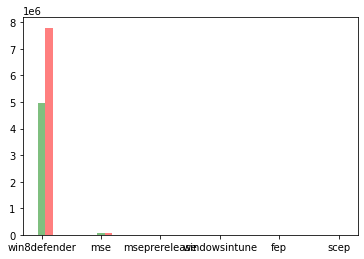

features: EngineVersion


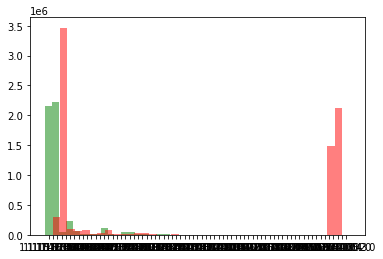

features: AppVersion


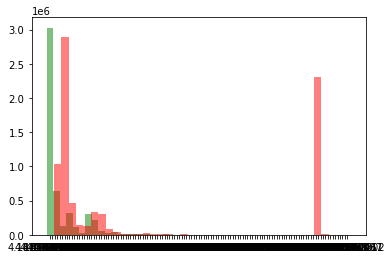

features: AvSigVersion


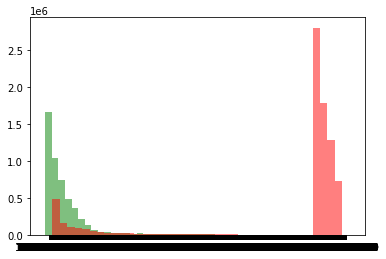

features: IsBeta


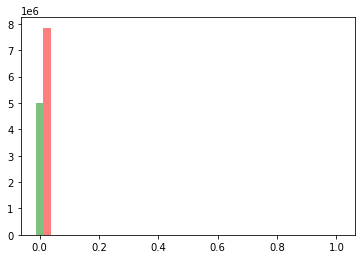

features: RtpStateBitfield


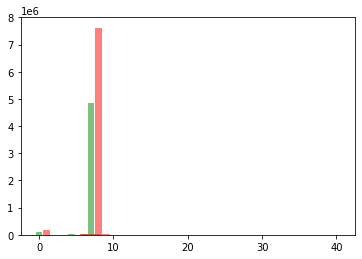

features: IsSxsPassiveMode


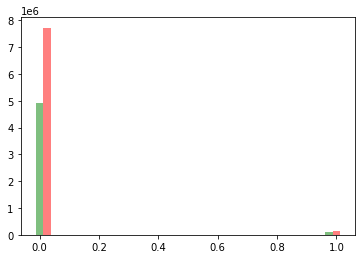

features: DefaultBrowsersIdentifier


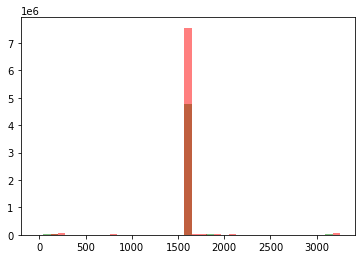

features: AVProductStatesIdentifier


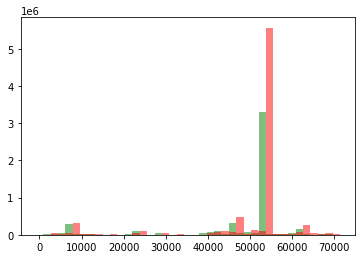

features: AVProductsInstalled


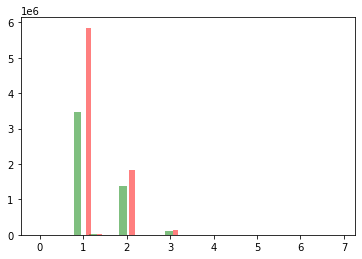

features: AVProductsEnabled


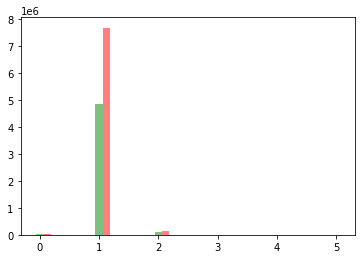

features: HasTpm


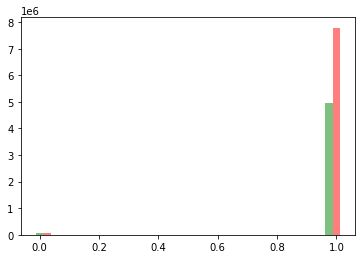

features: CountryIdentifier


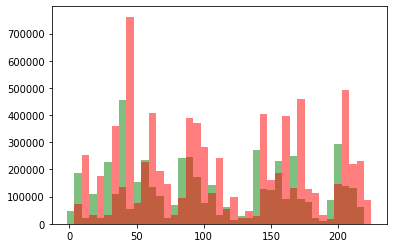

features: CityIdentifier


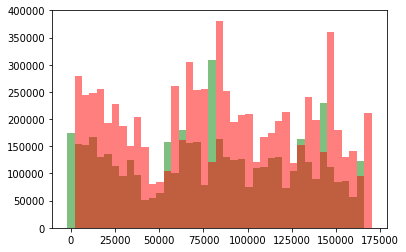

features: OrganizationIdentifier


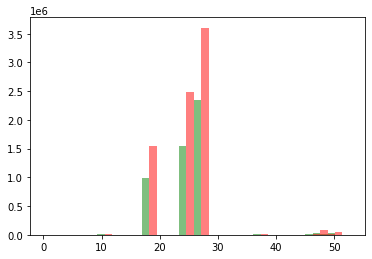

features: GeoNameIdentifier


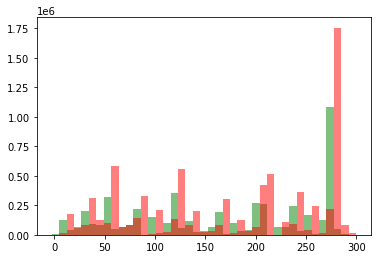

features: LocaleEnglishNameIdentifier


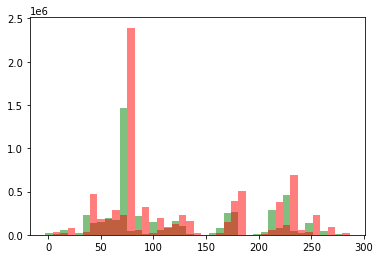

features: Platform


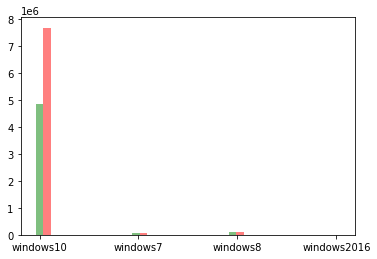

features: Processor


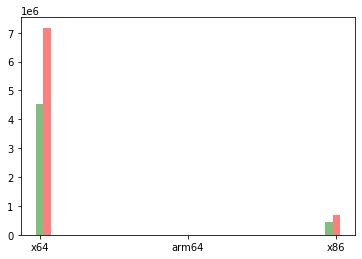

features: OsVer


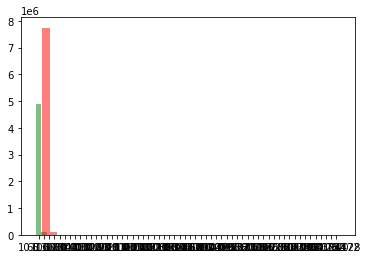

features: OsBuild


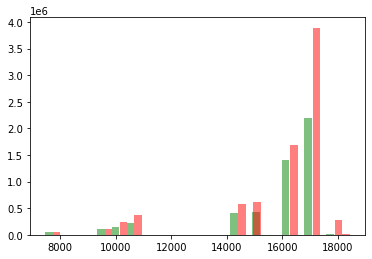

features: OsSuite


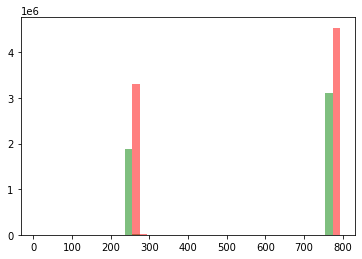

features: OsPlatformSubRelease


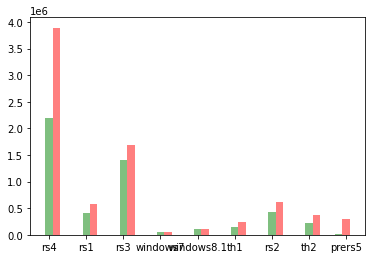

features: OsBuildLab


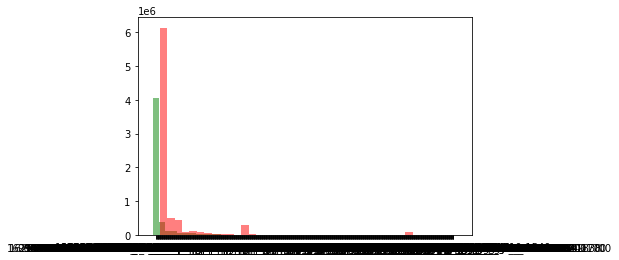

features: SkuEdition


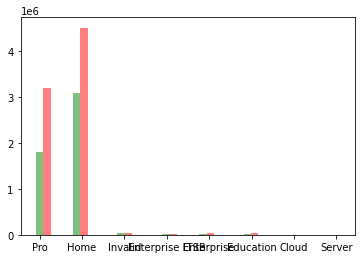

features: IsProtected


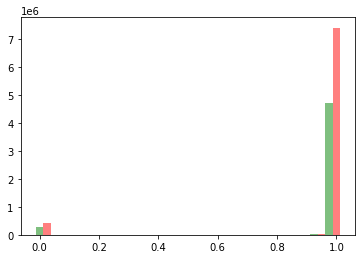

features: AutoSampleOptIn


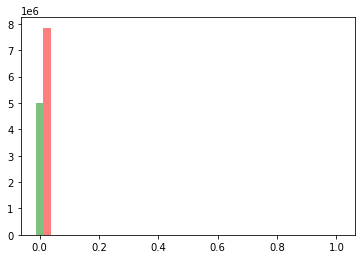

features: PuaMode


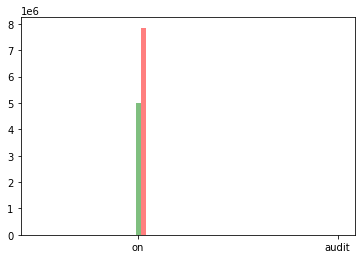

features: SMode


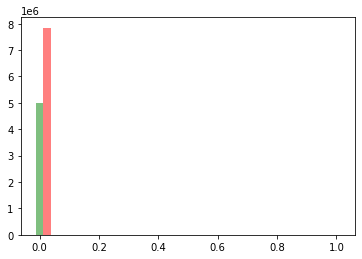

features: IeVerIdentifier


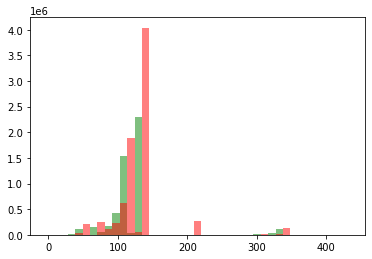

features: SmartScreen


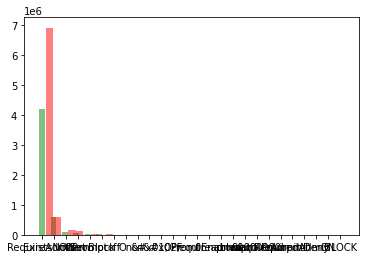

features: Firewall


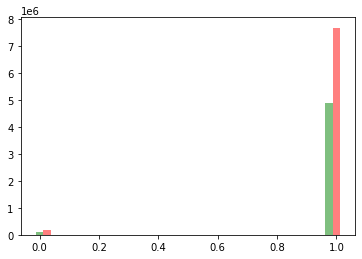

features: UacLuaenable


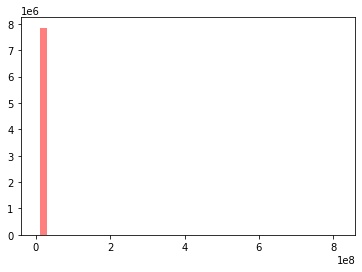

features: Census_MDC2FormFactor


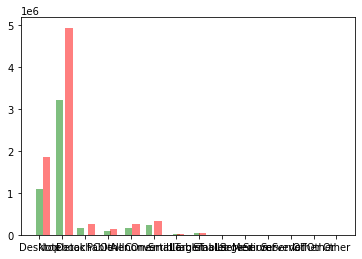

features: Census_DeviceFamily


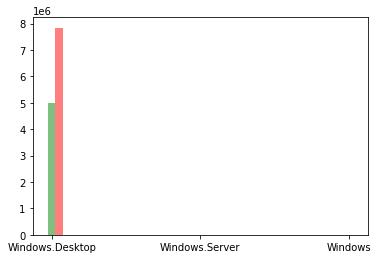

features: Census_OEMNameIdentifier


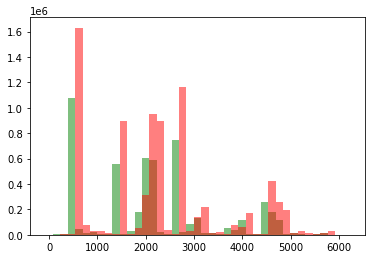

features: Census_OEMModelIdentifier


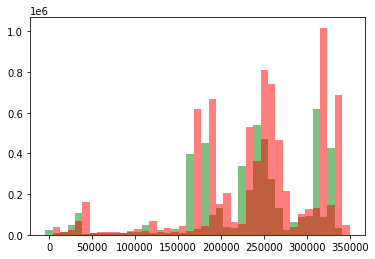

features: Census_ProcessorCoreCount


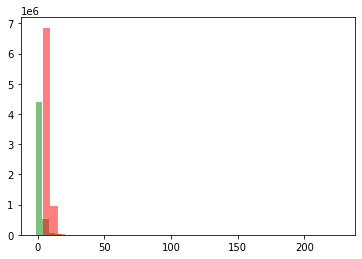

features: Census_ProcessorManufacturerIdentifier


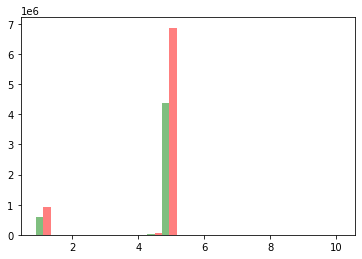

features: Census_ProcessorModelIdentifier


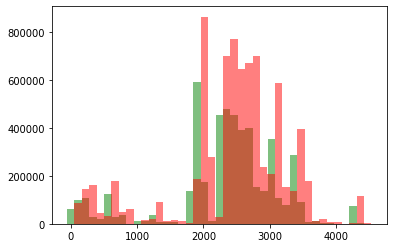

features: Census_ProcessorClass


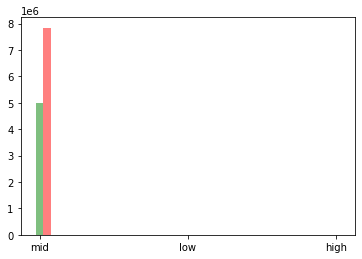

features: Census_PrimaryDiskTotalCapacity


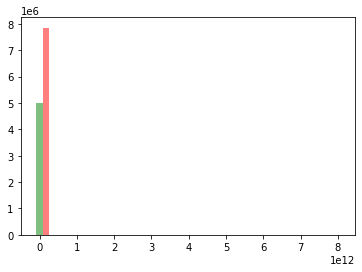

features: Census_PrimaryDiskTypeName


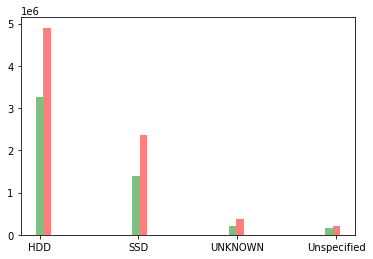

features: Census_SystemVolumeTotalCapacity


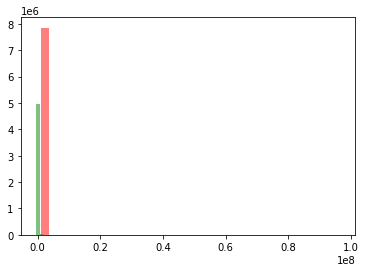

features: Census_HasOpticalDiskDrive


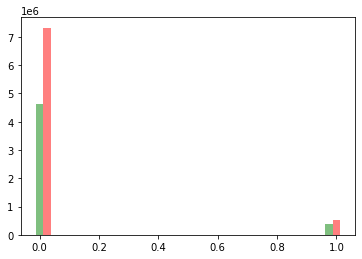

features: Census_TotalPhysicalRAM


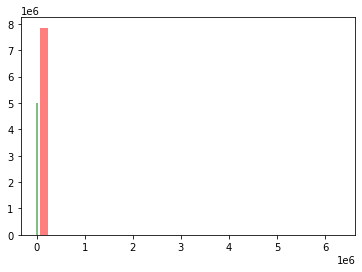

features: Census_ChassisTypeName


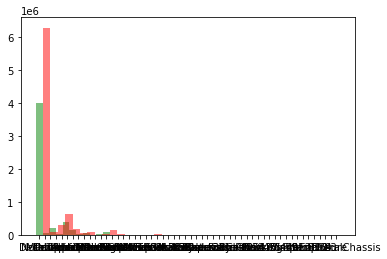

features: Census_InternalPrimaryDiagonalDisplaySizeInInches


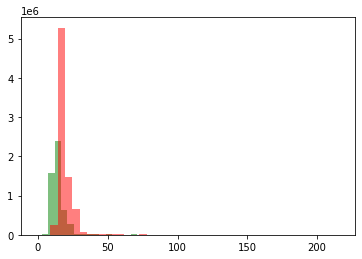

features: Census_InternalPrimaryDisplayResolutionHorizontal


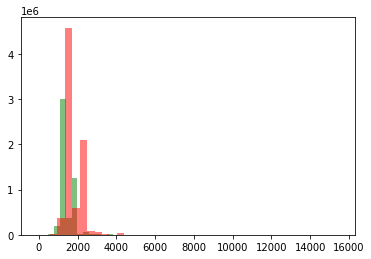

features: Census_InternalPrimaryDisplayResolutionVertical


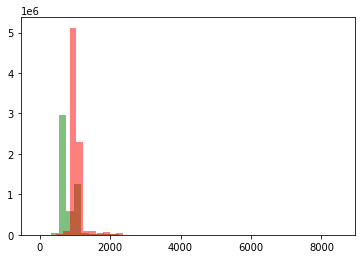

features: Census_PowerPlatformRoleName


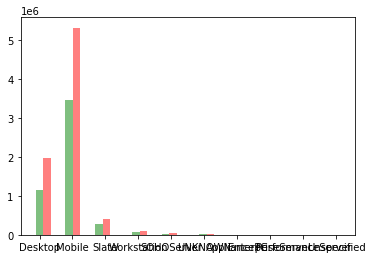

features: Census_InternalBatteryType


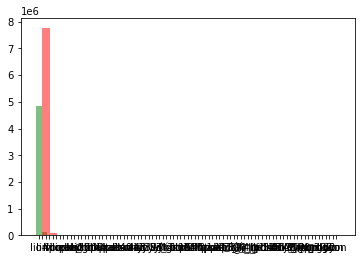

features: Census_InternalBatteryNumberOfCharges


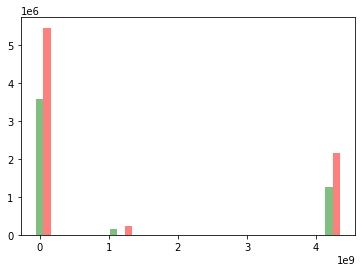

features: Census_OSVersion


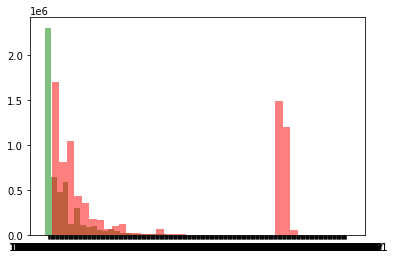

features: Census_OSArchitecture


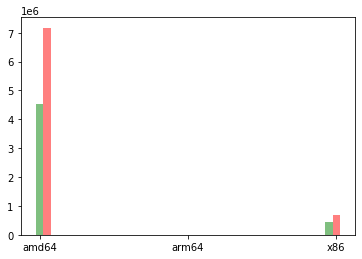

features: Census_OSBranch


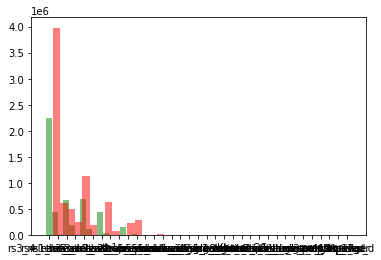

features: Census_OSBuildNumber


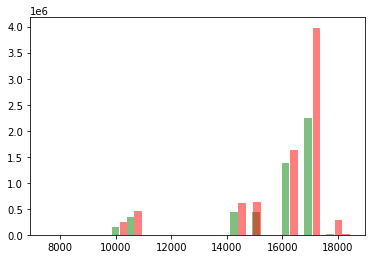

features: Census_OSBuildRevision


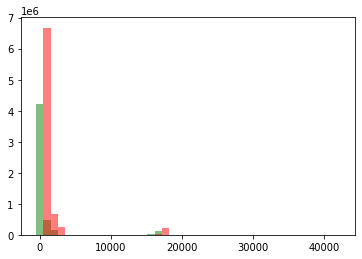

features: Census_OSEdition


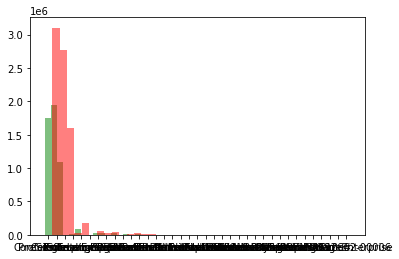

features: Census_OSSkuName


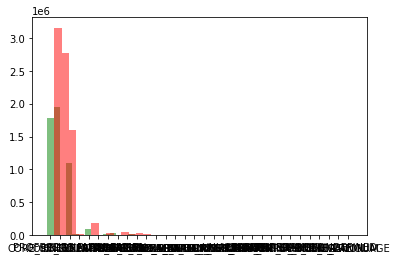

features: Census_OSInstallTypeName


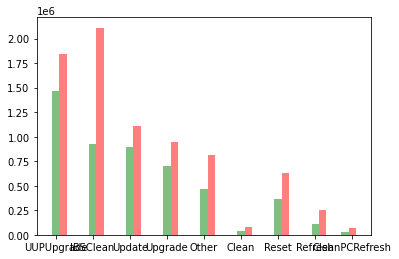

features: Census_OSInstallLanguageIdentifier


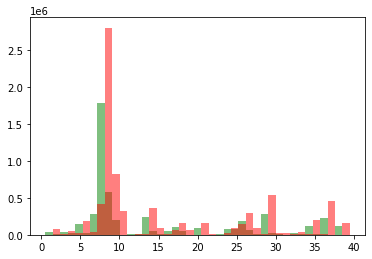

features: Census_OSUILocaleIdentifier


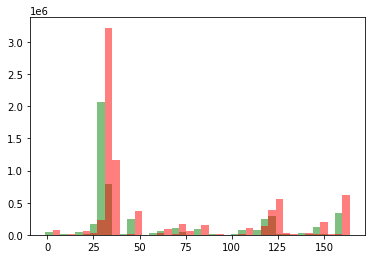

features: Census_OSWUAutoUpdateOptionsName


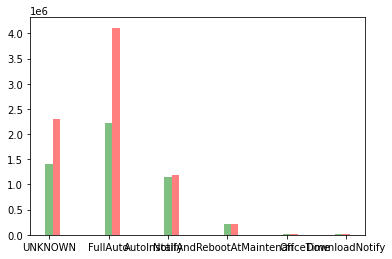

features: Census_IsPortableOperatingSystem


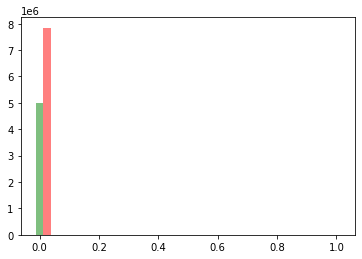

features: Census_GenuineStateName


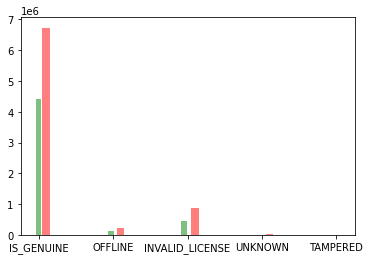

features: Census_ActivationChannel


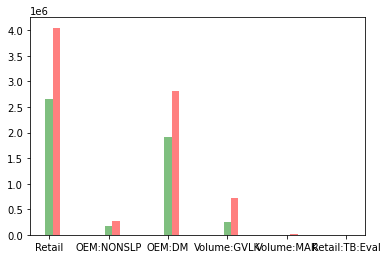

features: Census_IsFlightingInternal


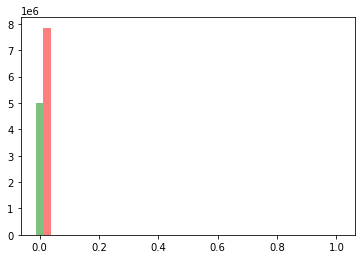

features: Census_IsFlightsDisabled


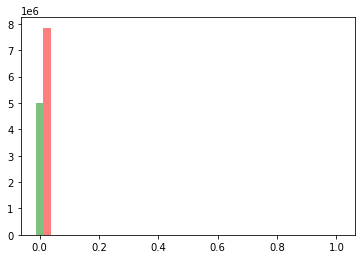

features: Census_FlightRing


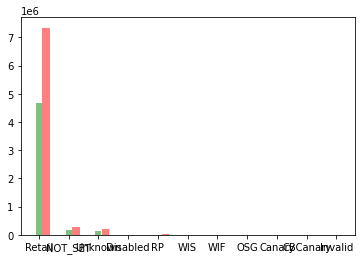

features: Census_ThresholdOptIn


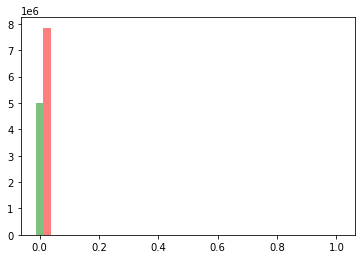

features: Census_FirmwareManufacturerIdentifier


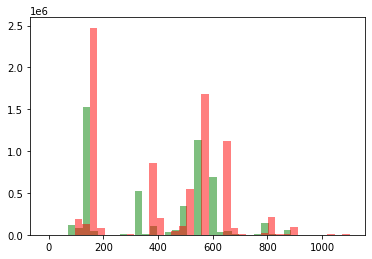

features: Census_FirmwareVersionIdentifier


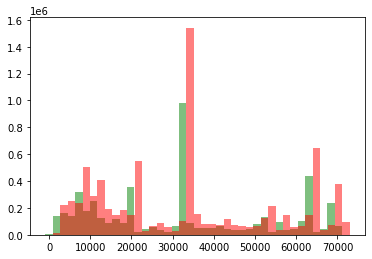

features: Census_IsSecureBootEnabled


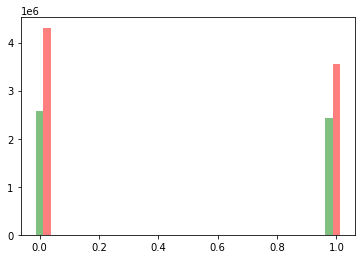

features: Census_IsWIMBootEnabled


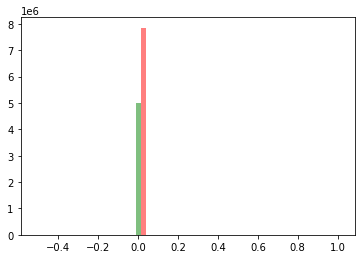

features: Census_IsVirtualDevice


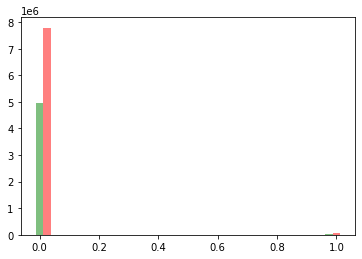

features: Census_IsTouchEnabled


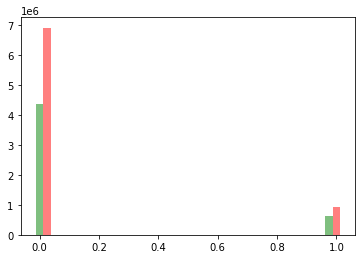

features: Census_IsPenCapable


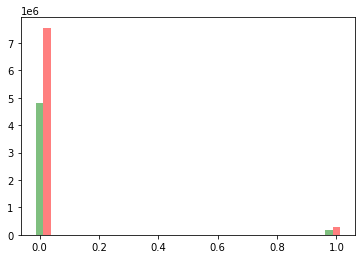

features: Census_IsAlwaysOnAlwaysConnectedCapable


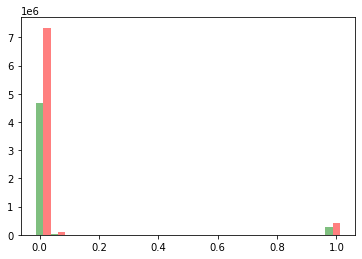

features: Wdft_IsGamer


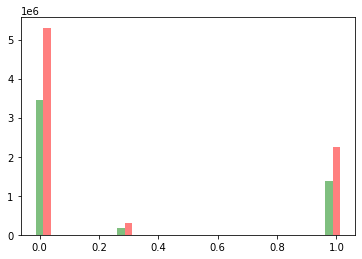

features: Wdft_RegionIdentifier


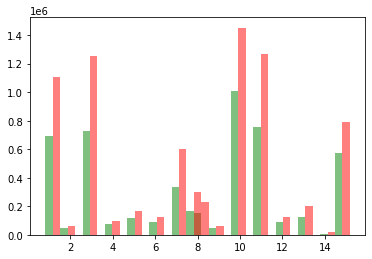

features: origin


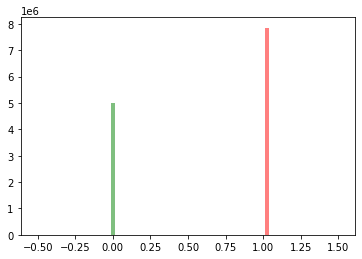

In [0]:
features_show= df_test.columns 
combine_df=pd.concat([df_train,df_test], axis=0, ignore_index=True)
for x in features_show:
  plt.hist(combine_df.loc[combine_df['origin'] == 0,x], bins=40,align='left', color="green",alpha=.5, label="train")
  plt.hist(combine_df.loc[combine_df['origin'] == 1,x], bins=40,align='right',color="red",alpha=.5, label="test")
  plt.title=x
  print('features:',x)
  plt.show()

==> Conclusion: Based on the different distribution of input value from each field of Train and Test dataset, we can determine the covariate fields are:
- 'EngineVersion','AppVersion','AvSigVersion','IsBeta','UacLuaenable','Census_ProcessorModelIdentifier','Census_OSVersion','Census_OSEdition','Census_OSSkuName','origin'

# 3. Build classifier prediction 

In [0]:
# get high covariate shift features from 2
drop_list=['EngineVersion','AppVersion','AvSigVersion',
           'IsBeta','UacLuaenable','Census_ProcessorModelIdentifier','Census_OSVersion',
           'Census_OSEdition','Census_OSSkuName','origin']
remain_features=[]
for x in list(df_test.columns):
  if(x not in drop_list):
    remain_features.append(x)
# show remain features use for build classifier model
#remain_features

In [0]:
from sklearn.model_selection import train_test_split

#Get the values and run a classifier 
features= remain_features

# convert to dummies
X=df_train[features]
y=df_train['HasDetections']

# 70% train, 30% test from dataset train.csv
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)


In [0]:
# Build prediction Model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# main Model
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [0]:
# cross validation model
scores = cross_val_score(clf, X_test, y_test, cv=4,scoring=make_scorer(accuracy_score))
#Report the results of 4-Kfold stratified cross-validation
print("ACC: %0.5f +/- %0.5f" % (scores.mean(), scores.std()))

ACC: 0.61517 +/- 0.00053


4.1 Test On test.csv

In [0]:
# Load Test Data all
#df_test = pd.read_csv("test.csv",skiprows=0)
export_file='as2_experiment02.csv'
features= remain_features
testFeatures=df_test[features].copy()
pred = clf.predict(testFeatures)
columns = ['HasDetections']
sub = pd.DataFrame(data=pred,columns=columns)
sub['MachineIdentifier'] = df_test_id
sub = sub[['MachineIdentifier','HasDetections']]
sub.to_csv(export_file, index=False)

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': export_file})
upload.SetContentFile(export_file)
upload.Upload()